Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [2]:
# install necessary dependencies
# !pip install -r requirements.txt

In [3]:
# from jax.config import config
# config.update('jax_enable_x64', True)

import jax.numpy as jnp
import jax

import matplotlib
import matplotlib.pyplot as plt

from importlib import reload

In [4]:
from trajax import integrators
from trajax.experimental.sqp import shootsqp, util

In [5]:
reload(shootsqp)
reload(util)

<module 'trajax.experimental.sqp.util' from '/home/dung10/code/trajax/.venv/lib/python3.10/site-packages/trajax/experimental/sqp/util.py'>

# Define Problem

## Setup Obstacle environment

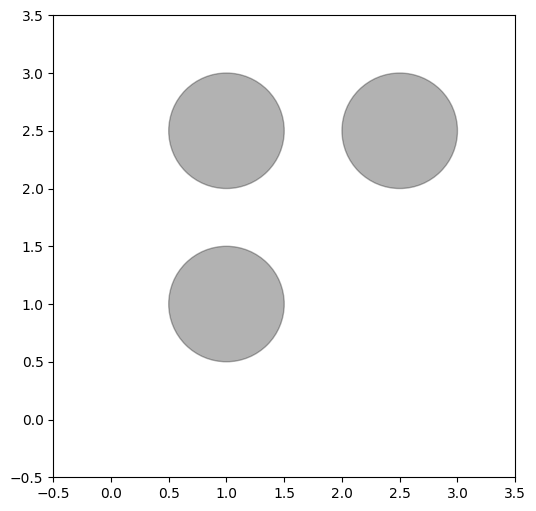

In [6]:
# @title {vertical-output: true}

obs = [(jnp.array([1., 1.]), 0.5),
          (jnp.array([1, 2.5]), 0.5),
          (jnp.array([2.5, 2.5]), 0.5)]

def render_scene():
  # Setup obstacle environment for state constraint
  world_range = (jnp.array([-0.5, -0.5]), jnp.array([3.5, 3.5]))

  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  plt.grid(False)

  for ob in obs:
    ax.add_patch(plt.Circle(ob[0], ob[1], color='k', alpha=0.3))
  ax.set_xlim([world_range[0][0], world_range[1][0]])
  ax.set_ylim([world_range[0][1], world_range[1][1]])

  ax.set_aspect('equal')
  return fig, ax

_ = render_scene()

## Setup Dynamics, cost, constraints

In [7]:
# Setup discrete-time dynamics
def car_ode(x, u, t):
  del t
  return jnp.array([x[3] * jnp.sin(x[2]),
                    x[3] * jnp.cos(x[2]),
                    x[3] * u[0],
                    u[1]])
dt = 0.05
dynamics = integrators.euler(car_ode, dt=dt)

# Constants
n, m, T = (4, 2, 40)

# Indices of state corresponding to S1 sphere constraints
s1_indices = (2,)
state_wrap = util.get_s1_wrapper(s1_indices)


# Cost function.
R = jnp.diag(jnp.array([0.2, 0.1]))
Q_T = jnp.diag(jnp.array([50., 50., 50., 10.]))
goal_default = jnp.array([3., 3., jnp.pi/2, 0.])

@jax.jit
def cost(x, u, t, goal=goal_default):
  stage_cost = dt * jnp.vdot(u, R @ u)
  delta = state_wrap(x - goal)
  term_cost = jnp.vdot(delta, Q_T @ delta)
  return jnp.where(t == T, term_cost, stage_cost)

# Control box bounds
control_bounds = (jnp.array([-jnp.pi/3., -6.]),
                  jnp.array([jnp.pi/3., 6.]))

# Obstacle avoidance constraint function
def obs_constraint(pos):
  def avoid_obs(pos_c, ob):
    delta_body = pos_c - ob[0]
    delta_dist_sq = jnp.vdot(delta_body, delta_body) - (ob[1]**2)
    return delta_dist_sq
  return jnp.array([avoid_obs(pos, ob) for ob in obs])

# State constraint function
@jax.jit
def state_constraint(x, t):
  del t
  pos = x[0:2]
  return obs_constraint(pos)

# Define Solver

In [8]:
# Define Solver
solver_options = dict(method=shootsqp.SQP_METHOD.SENS,
                      ddp_options={'ddp_gamma': 1e-4},
                      hess="full", verbose=True,
                      max_iter=100, ls_eta=0.49, ls_beta=0.8,
                      primal_tol=1e-3, dual_tol=1e-3, stall_check="abs",
                      debug=False)
solver = shootsqp.ShootSQP(n, m, T, dynamics, cost, control_bounds,
                           state_constraint, s1_ind=s1_indices, **solver_options)

In [9]:
# Variations to try:
# method={OPEN, SENS}
# proj_init={FALSE, TRUE}

# Solve

## Set initial conditions and guess

In [10]:
# Set initial conditions and problem parameters
# x0 = jnp.zeros((n,))
# x0 = jnp.array([0.25, 1.75, 0., 0.])
x0 = jnp.array([1.75, 1.0, 0., 0.])
U0 = jnp.zeros((T, m))
X0 = None
solver.opt.proj_init = False

In [11]:
# Optional X0 guess (must set solver.opt.proj_init = True)
solver.opt.proj_init = True
waypoints = jnp.array([
    x0[:2], jnp.array([1.75, 3.0]), goal_default[:2]
])
X0 = jnp.concatenate((
    jnp.linspace(waypoints[0], waypoints[1], int(T//2)),
    jnp.linspace(waypoints[1], waypoints[2], int(T//2) + 2)[1:]
))
# Augment with zeros
X0 = jnp.hstack((X0, jnp.zeros((T+1, 2))))

## Solve

In [12]:
# Run for one iteration to jit first
solver.opt.max_iter = 1
_ = solver.solve(x0, U0, X0)

{'cslack': (Array(0., dtype=float32), Array(0., dtype=float32)), 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)), 'obj': Array(204.29247, dtype=float32), 'primal': (Array(0., dtype=float32), Array(0.3125, dtype=float32)), 'stat': Array(21.15928, dtype=float32)}
Status: ERROR, obj: 204.29246520996094


In [13]:
# Run to completion
solver.opt.max_iter = 100
soln = solver.solve(x0, U0, X0)

{'cslack': (Array(0., dtype=float32), Array(0., dtype=float32)), 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)), 'obj': Array(204.29247, dtype=float32), 'primal': (Array(0., dtype=float32), Array(0.3125, dtype=float32)), 'stat': Array(21.15928, dtype=float32)}
Status: ERROR, obj: 204.29246520996094


In [14]:
print(soln.iterations, soln.objective)
soln.kkt_residuals

0 204.29247


{'cslack': (Array(0., dtype=float32), Array(0., dtype=float32)),
 'dual': (Array(0., dtype=float32), Array(0., dtype=float32)),
 'obj': Array(204.29247, dtype=float32),
 'primal': (Array(0., dtype=float32), Array(0.3125, dtype=float32)),
 'stat': Array(21.15928, dtype=float32)}

# Plot solution

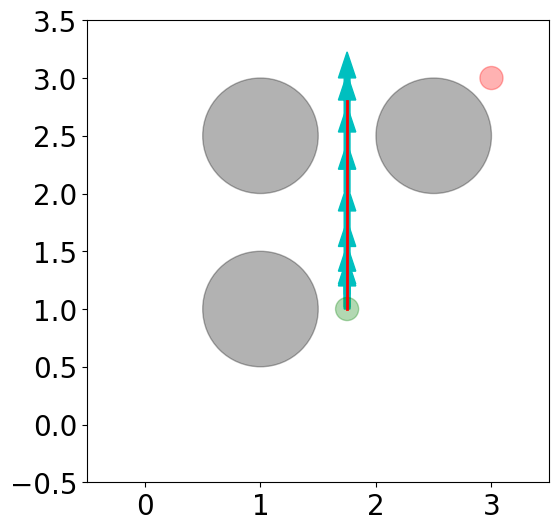

In [15]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = render_scene()
U, X = soln.primals
ax.plot(X[:, 0], X[:, 1], 'r-', linewidth=2)

for t in jnp.arange(0, solver._T+1, 5):
  ax.arrow(X[t, 0], X[t, 1],
      0.2 * jnp.sin(X[t, 2]), 0.2 * jnp.cos(X[t, 2]),
      width=0.05, color='c')

# Start
ax.add_patch(plt.Circle([x0[0], x0[1]], 0.1, color='g', alpha=0.3))
# End
ax.add_patch(plt.Circle([goal_default[0], goal_default[1]], 0.1, color='r', alpha=0.3))

ax.set_aspect('equal')

Text(0.5, 0, 'Time [s]')

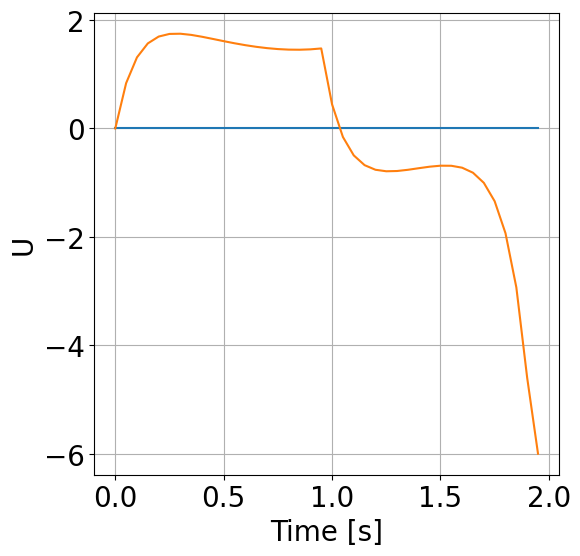

In [16]:
# @title {vertical-output: true}
%matplotlib inline

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(True)
plt.plot(solver._timesteps[:-1]*dt, U, markersize=5)
ax.set_ylabel('U')
ax.set_xlabel('Time [s]')


# Plot solver progress

In [17]:
import seaborn as sns
colors = sns.color_palette("tab10")

In [18]:
history = soln.history
history.keys()

dict_keys(['steplength', 'obj', 'min_viol', 'ddp_err', 'ddp_err_grad'])

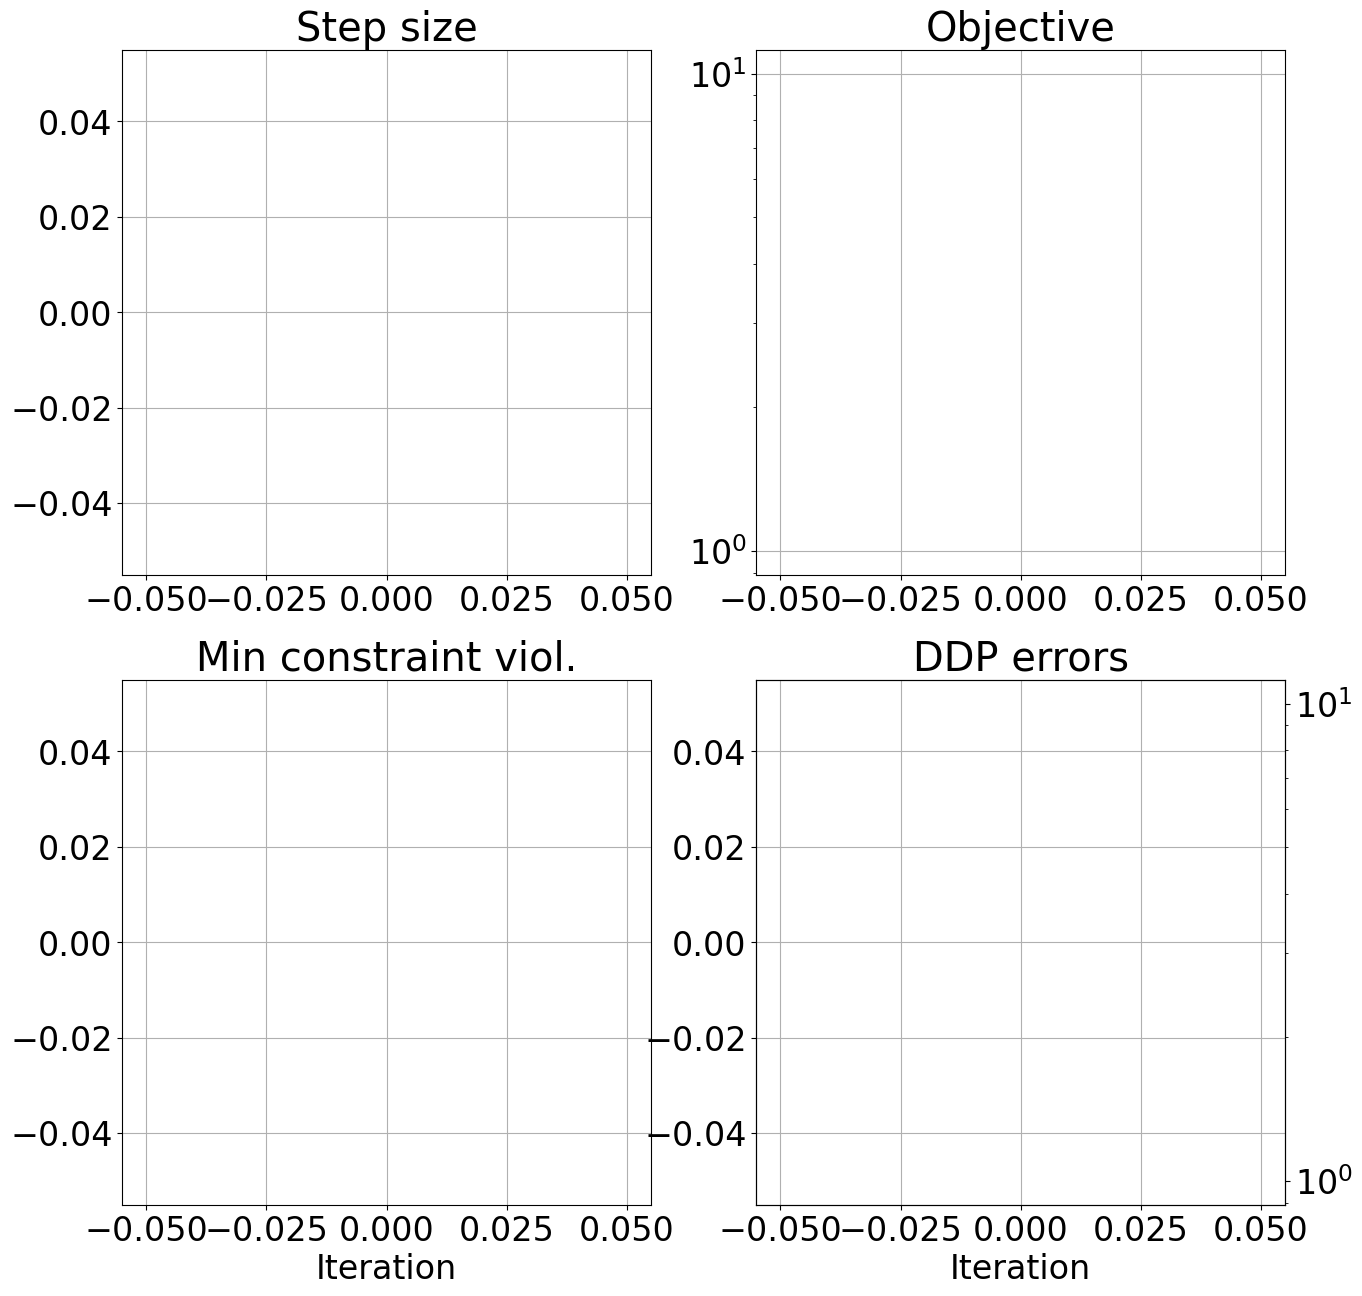

In [19]:
#@title {vertical-output: true}
%matplotlib inline

plt.rcParams.update({'font.size': 24})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].plot(history['steplength'], color=colors[0], linewidth=2)
axs[0][0].set_title('Step size')
axs[0][0].grid(True)

axs[0][1].plot(history['obj'], color=colors[0], linewidth=2)
axs[0][1].set_title('Objective')
axs[0][1].set_yscale('log')
axs[0][1].grid(True)

axs[1][0].plot(history['min_viol'], color=colors[0], linewidth=2)
axs[1][0].set_title('Min constraint viol.')
axs[1][0].set_xlabel('Iteration')
axs[1][0].grid(True)

if 'ddp_err' in history:
  axs[1][1].plot(history['ddp_err'], color=colors[0], linewidth=2)
  axs2 = axs[1][1].twinx()
  axs2.plot(history['ddp_err_grad'], color=colors[1], linewidth=2)
  axs2.set_yscale("log")
  axs[1][1].set_title('DDP errors')
  axs[1][1].set_xlabel('Iteration')
  axs[1][1].grid(True)